TESTED FEATURES: 
Index(['vel5', 'vel10', 'vel15', 'vel30', 'vel60', 'acc5', 'acc10', 'acc15',
       'acc30', 'acc60', 'stoch12', 'stochDiff6012', 'RSIhl_diff',
       'RSIhl_diffROC', 'vol', 'vol10', 'vol15', 'vol30', 'vol60', 'volD10',
       'volD15', 'volD30', 'volD60', 'vpm5', 'vpm10', 'vpm15', 'vpm30',
       'vpm60', 'ToD', 'DoW', 'MO'],
      dtype='object')
TESTING FOR: 
Dr3
X shape == (2800, 6, 31).
y shape == (2800,).
-0.004011168410071971
1.5208545801094324
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


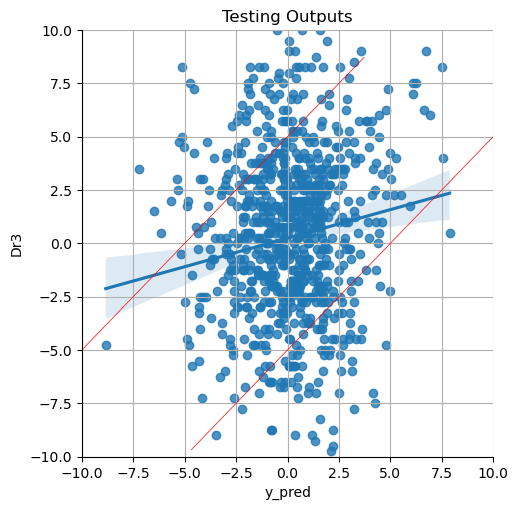

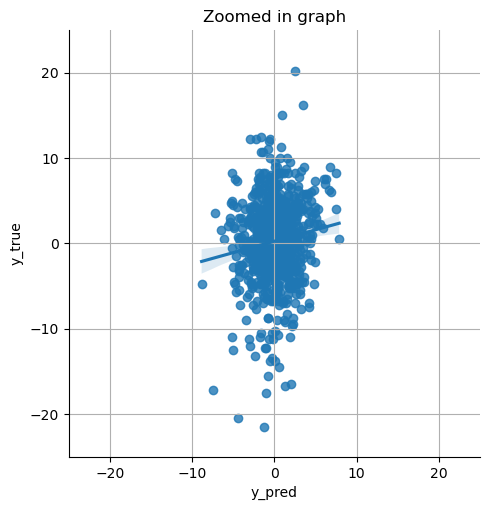

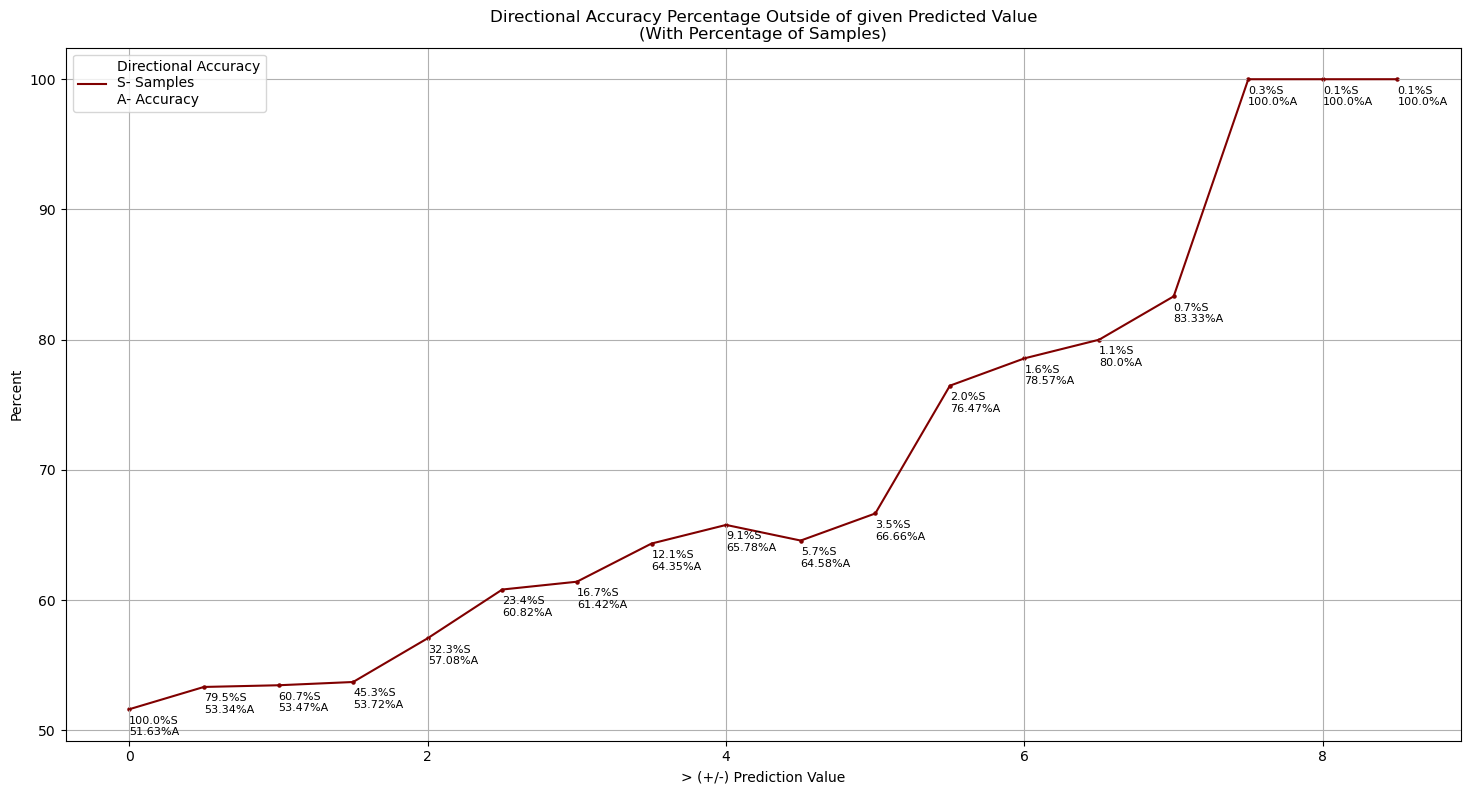

In [84]:
#JJ McCauley + LOGAN KELSCH 
#TEST NN 1

#IMPORT LIBRARIES-------------------------------------------------------

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from keras.optimizers import SGD
from keras.initializers import GlorotUniform
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

#hahaha dont turn this on with high epoch or else
#tf.config.experimental.set_memory_growth

#LOAD DATA FROM CSV-------------------------------------------------------

# Load the dataset
data = pd.read_csv('catted_10day.csv')
dataTRAIN = pd.read_csv('catted_1.csv')

#      'Dr1' 'Dr3' 'Mr1' 'Mr3' 
testFor = 'Dr3'
timeSteps = 6
tType = testFor[0]
#testing random feature drops
#TREND

data = data.drop(columns='FT')
data = data.drop(columns='FT.1')
data = data.drop(columns='FT.2')
data = data.drop(columns='YM_diff')
data = data.drop(columns='NQ_diff')
data = data.drop(columns='volNQdiff')
data = data.drop(columns='volYMdiff')
dataTRAIN = dataTRAIN.drop(columns='FT')
dataTRAIN = dataTRAIN.drop(columns='FT.1')
dataTRAIN = dataTRAIN.drop(columns='FT.2')
dataTRAIN = dataTRAIN.drop(columns='YM_diff')
dataTRAIN = dataTRAIN.drop(columns='NQ_diff')
dataTRAIN = dataTRAIN.drop(columns='volNQdiff')
dataTRAIN = dataTRAIN.drop(columns='volYMdiff')
'''
data = data.drop(columns='vol60')
data = data.drop(columns='volD10')
data = data.drop(columns='volD15')
data = data.drop(columns='volD30')
data = data.drop(columns='volD60')
data = data.drop(columns='vpm5')
data = data.drop(columns='vpm10')
data = data.drop(columns='vpm15')
data = data.drop(columns='vpm30')
data = data.drop(columns='vpm60')
data = data.drop(columns='acc30')
data = data.drop(columns='acc60')
dataTRAIN = dataTRAIN.drop(columns='vol60')
dataTRAIN = dataTRAIN.drop(columns='volD10')
dataTRAIN = dataTRAIN.drop(columns='volD15')
dataTRAIN = dataTRAIN.drop(columns='volD30')
dataTRAIN = dataTRAIN.drop(columns='volD60')
dataTRAIN = dataTRAIN.drop(columns='vpm5')
dataTRAIN = dataTRAIN.drop(columns='vpm10')
dataTRAIN = dataTRAIN.drop(columns='vpm15')
dataTRAIN = dataTRAIN.drop(columns='vpm30')
dataTRAIN = dataTRAIN.drop(columns='vpm60')
dataTRAIN = dataTRAIN.drop(columns='acc30')
dataTRAIN = dataTRAIN.drop(columns='acc60')
'''

#CALENDAR
#--------------------------------------
#SOLUTION------------------------------
data = data.drop(columns=['Mc1','Mc3','Dc1','Dc3'])
dataTRAIN = dataTRAIN.drop(columns=['Mc1','Mc3','Dc1','Dc3'])
match testFor:
    case 'Dr1':
        data = data.drop(columns='Dr3')
        data = data.drop(columns='Mr1')
        data = data.drop(columns='Mr3')
        dataTRAIN = dataTRAIN.drop(columns='Dr3')
        dataTRAIN = dataTRAIN.drop(columns='Mr1')
        dataTRAIN = dataTRAIN.drop(columns='Mr3')
    case 'Dr3':
        data = data.drop(columns='Dr1')
        data = data.drop(columns='Mr1')
        data = data.drop(columns='Mr3')
        dataTRAIN = dataTRAIN.drop(columns='Dr1')
        dataTRAIN = dataTRAIN.drop(columns='Mr1')
        dataTRAIN = dataTRAIN.drop(columns='Mr3')
    case 'Mr1':
        data = data.drop(columns='Dr1')
        data = data.drop(columns='Dr3')
        data = data.drop(columns='Mr3')
        dataTRAIN = dataTRAIN.drop(columns='Dr1')
        dataTRAIN = dataTRAIN.drop(columns='Dr3')
        dataTRAIN = dataTRAIN.drop(columns='Mr3')
    case 'Mr3':
        data = data.drop(columns='Dr1')
        data = data.drop(columns='Dr3')
        data = data.drop(columns='Mr1')
        dataTRAIN = dataTRAIN.drop(columns='Dr1')
        dataTRAIN = dataTRAIN.drop(columns='Dr3')
        dataTRAIN = dataTRAIN.drop(columns='Mr1')


#confirming X and Y features post training
Xfeatures = data.columns[:-1]
Yfeatures = data.columns[-1]
print("TESTED FEATURES: ")
print(Xfeatures)
print("TESTING FOR: ")
print(Yfeatures)

# Separate features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

XTRAIN = dataTRAIN.iloc[:, :-1].values
yTRAIN = dataTRAIN.iloc[:, -1].values

# Standardize the features
scaler1 = StandardScaler()
scaler2 = RobustScaler()
scaler3 = MinMaxScaler(feature_range=(-1,1))

percFit = 0.8
fitSplit = len(X)//(1/(percFit))
negFitSplit = len(X)//(1/(1-percFit))

scaler1.fit(XTRAIN)
XTRAIN = scaler1.transform(XTRAIN)
#scaler2.fit(XTRAIN)
#XTRAIN = scaler2.transform(XTRAIN)
#scaler3.fit(XTRAIN)
#XTRAIN = scaler3.transform(XTRAIN)
X = scaler1.transform(X)
#X = scaler2.transform(X)
#X = scaler3.transform(X)
#scaler3.fit(XTRAIN)


#X = scaler3.transform(X)

#setting data for LSTM
def reformat_to_lstm(X, time_steps=timeSteps):
    X_lstm, y_lstm = [], []
    
    for i in range(time_steps, len(X)):
        # Collect previous time_steps rows for X
        X_lstm.append(X[i-time_steps:i])  
        # The corresponding y value for the last time step in the sequence
    
    X_lstm = np.array(X_lstm)
    
    return X_lstm

X = reformat_to_lstm(X, timeSteps)
y = y[timeSteps:]
y = np.array(y)

XTRAIN = reformat_to_lstm(XTRAIN, timeSteps)
yTRAIN = yTRAIN[timeSteps:]
yTRAIN = np.array(yTRAIN)

print('X shape == {}.'.format(X.shape))
print('y shape == {}.'.format(y.shape))


mos = X[:, timeSteps-1, len(Xfeatures)-1].mean()
print(mos)

def remove_zero_mo_samples(X, y):
    # Get the 'MO' column (index 34 for 0-based indexing) for all time steps and samples
    non_zero_indices = (X[:, timeSteps-1, len(Xfeatures)-1] >= 0)
    # Filter X and y using these indices
    X_filtered = X[non_zero_indices]
    y_filtered = y[non_zero_indices]
    return X_filtered, y_filtered

X, y = remove_zero_mo_samples(X, y)
#XTRAIN, yTRAIN = remove_zero_mo_samples(XTRAIN, yTRAIN)

mos = X[:, timeSteps-1, len(Xfeatures)-1].mean()
print(mos)

loaded_model = tf.keras.models.load_model('LSTM_Dr3_6step_10.keras')
loaded_model.compile(optimizer='adam',
                  loss='mse'
                  ,metrics=['R2Score','root_mean_squared_error'])

#predicting the test set results
y_pred = loaded_model.predict(X) 

import seaborn as sns
y_pred = np.squeeze(y_pred)
y = np.squeeze(y)
ys = pd.DataFrame({"y_pred":y_pred,"y_true":y})
#data.insert(1, "y_pred", y_pred, True)
# plot 1 with axes level-plot
g = sns.lmplot(data=ys,x="y_pred", y="y_true")#, hue="MO")

#plt.scatter(y_pred, y, s=1)
plt.axis('tight')
plt.grid()
plt.title('Testing Outputs')
plt.xlabel('y_pred')
plt.ylabel(testFor)

# Get the current axes from the lmplot
ax = plt.gca()

# Define the limits for the line (should cover the same range as your plot)
x_vals = np.array(ax.get_xlim())
y_vals = x_vals  # Since y = x

# Plot the y=x line
plt.plot(x_vals+5, y_vals, '-', color='red', label='y = x', linewidth=0.5)
plt.plot(x_vals-5, y_vals, '-', color='red', label='y = x', linewidth=0.5)

match tType:
    case 'D':
        plt.xlim(-10,10)
        plt.ylim(-10,10)
    case _:
        plt.xlim(0,5)
        plt.ylim(0,5)
plt.show()

g = sns.lmplot(data=ys,x="y_pred", y="y_true")#,hue="MO")
plt.title('Zoomed in graph')
plt.grid()
plt.xlim(-25,25)
plt.ylim(-25,25)
plt.show()

#DIRECTIONAL ACCURACY #DIRECTIONAL ACCURACY  #DIRECTIONAL ACCURACY  #DIRECTIONAL ACCURACY  #DIRECTIONAL ACCURACY  
specGuess = 10
specAcc = []
valCount = []
for v in range(0,specGuess*2):
    tp, fp, tn, fn = 0, 0, 0, 0
    tp5, fp5, tn5, fn5 = 0, 0, 0, 0
    valCnt = 0
    y_pred = ys['y_pred']
    y_test = ys['y_true']
    for i in range(len(y_pred)):
        if(y_pred[i]>0):
            if(y_test[i]>0):
                tp+=1
            if(y_test[i]<0):
                fp+=1
            if(y_pred[i]>=(v/2)):
                valCnt+=1
                if(y_test[i]>0):
                    tp5+=1
                if(y_test[i]<0):
                    fp5+=1
        if(y_pred[i]<0):
            if(y_test[i]<0):
                tn+=1
            if(y_test[i]>0):
                fn+=1
            if(y_pred[i]<=-(v/2)):
                valCnt+=1
                if(y_test[i]<0):
                    tn5+=1
                if(y_test[i]>0):
                    fn5+=1
    if((tp5+fp5+tn5+fn5)<1):
        break
    directionalAccuracy = ((tp+tn)/(tp+fp+tn+fn))*10000//1/100
    directionalAccuracy5guess = ((tp5+tn5)/(tp5+fp5+tn5+fn5))*10000//1/100
    specAcc.append(directionalAccuracy5guess)
    valCount.append(valCnt)
    #print(f'Directional Accuracy >(+/-){v/2}:\t',directionalAccuracy5guess)
#print('Directional Accuracy:\t\t',directionalAccuracy)
valCount = [x / valCount[0] * 100 for x in valCount]
plt.figure(figsize=(18, 9))
plt.plot(np.arange(0,0.5*len(specAcc),0.5), specAcc, 'maroon', label='Directional Accuracy')
plt.scatter(np.arange(0,0.5*len(specAcc),0.5), specAcc, s=5, color='maroon')
#plt.plot(np.arange(0,0.5*len(specAcc),0.5), valCount, 'r', label='% Of Samples')
plt.title('Directional Accuracy Percentage Outside of given Predicted Value\n(With Percentage of Samples)')
plt.xlabel('> (+/-) Prediction Value')
plt.ylabel('Percent')
plt.grid()
plt.legend(['Directional Accuracy\nS- Samples\nA- Accuracy'], loc='upper left')
for x, y in zip(np.arange(0,0.5*len(specAcc),0.5), specAcc):
    plt.annotate(f'{float(valCount[int(x*2)]*10//1/10)}%S\n{float(specAcc[int(x*2)])}%A', color='black', xy=(x, y-2), fontsize=8)
plt.show()

In [5]:
data.corr()
#print(X.shape)

,vel5,vel10,vel15,vel30,vel60,acc5,acc10,acc15,acc30,acc60,...,volD60,vpm5,vpm10,vpm15,vpm30,vpm60,ToD,DoW,MO,Dr3
vel5,1.000000,0.687578,0.575269,0.407828,0.289817,0.725868,0.477775,0.408135,0.288207,0.197416,...,-0.046718,0.471957,0.342412,0.287082,0.218135,0.175092,-0.005231,-0.019490,0.071790,-0.026836
vel10,0.687578,1.000000,0.804548,0.580599,0.413557,-0.000351,0.711954,0.560821,0.409159,0.291505,...,-0.068431,0.293414,0.492138,0.394496,0.293098,0.234884,-0.007961,-0.027849,0.104274,-0.010894
vel15,0.575269,0.804548,1.000000,0.706625,0.505659,0.030115,0.286262,0.712017,0.495723,0.360780,...,-0.056867,0.222323,0.359844,0.487512,0.339930,0.279033,-0.009207,-0.034132,0.124134,-0.011635
vel30,0.407828,0.580599,0.706625,1.000000,0.709722,0.011757,0.011864,0.006293,0.707494,0.515131,...,-0.022183,0.133572,0.218342,0.279992,0.475136,0.349809,-0.008743,-0.047926,0.156879,-0.008440
vel60,0.289817,0.413557,0.505659,0.709722,1.000000,0.007468,0.005443,0.010389,0.004266,0.711251,...,0.030176,0.099868,0.155286,0.200767,0.303309,0.478675,-0.003403,-0.062528,0.192399,0.016809
acc5,0.725868,-0.000351,0.030115,0.011757,0.007468,1.000000,-0.016466,0.030724,0.009368,-0.004167,...,0.000439,0.371945,0.005236,0.021563,0.022759,0.018660,0.000295,-0.000453,0.000124,-0.026635
acc10,0.477775,0.711954,0.286262,0.011864,0.005443,-0.016466,1.000000,0.392714,0.011232,-0.009767,...,-0.046961,0.238983,0.405746,0.178180,0.034289,0.026180,-0.003157,-0.000108,0.012130,0.000174
acc15,0.408135,0.560821,0.712017,0.006293,0.010389,0.030724,0.392714,1.000000,-0.001561,-0.001240,...,-0.058390,0.181533,0.291823,0.411112,0.008809,0.047102,-0.004167,-0.000837,0.019844,-0.008025
acc30,0.288207,0.409159,0.495723,0.707494,0.004266,0.009368,0.011232,-0.001561,1.000000,0.017708,...,-0.061651,0.089390,0.154021,0.195925,0.370031,0.016394,-0.009037,-0.005226,0.029841,-0.028770
acc60,0.197416,0.291505,0.360780,0.515131,0.711251,-0.004167,-0.009767,-0.001240,0.017708,1.000000,...,0.053651,0.065784,0.105425,0.141656,0.224467,0.368692,-0.008092,-0.018442,0.020835,0.014961
